# Hacer

- Separar día/mes de fecha [DONE]
- Codificar variables categóricas [DONE]
- Métricas: accuracy, recall y matriz de confusión 
- Borrar regresión lineal porque no sirve

### Definiciones

- Encoding de etiquetas: Día de la semana, se puede ordenar
- Binary encoding: Resto

## Usar

- Regresión lineal
- Árbol de decisión

https://chatgpt.com/share/671b97fb-7904-8006-853c-7d28072ea3c5

- Algún método no supervisado?

In [1]:

# Se importan librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math

In [2]:
def prepare_dataset(filepath):
    """
    Carga y preprocesa el dataset de peajes.
    """

    dataset = pd.read_csv(filepath)

    # Se eliminan las filas que contienen "Otros" en la columna "tipo_cobro"
    # Se toma esta decisión porque su impacto es mínimo
    dataset = dataset[dataset["tipo_cobro"] != "Otros"]

    # Se separa el día y el mes del año en columnas separadas
    # Necesitamos que las variables sean numéricas
    dataset["nro_dia"] = pd.to_datetime(dataset["fecha"]).dt.day
    dataset["nro_mes"] = pd.to_datetime(dataset["fecha"]).dt.month
    dataset["anio"] = pd.to_datetime(dataset["fecha"]).dt.year
    dataset.drop("fecha", axis=1, inplace=True)

    return dataset

In [3]:
def encode_columns(dataset):
    """
    Codifica las columnas del dataset que tienen variables cualitativas.
    """

    dataset = dataset.copy()

    # Se codifica la categoría día de la semana con label encoding (codificación de etiquetas)
    # Se toma esta decisión porque la variable es ordinal
    day_encoding = {
        'Lunes': 0,
        'Martes': 1,
        'Miercoles': 2,
        'Jueves': 3,
        'Viernes': 4,
        'Sabado': 5,
        'Domingo': 6
    }

    dataset['dia_semana'] = dataset['dia'].map(day_encoding)
    dataset.drop("dia", axis=1, inplace=True)

    # Se codifica el resto de las variables categóricas con binary encoding (codificación binaria)
    binary_encoder = ce.BinaryEncoder(cols=["id_peaje", "sentido", "tipo_vehiculo", "tipo_cobro"])
    dataset = binary_encoder.fit_transform(dataset)
    # Eliminamos las columnas sentido_1 y tipo_vehiculo_1 porque no aportan información
    dataset.drop(["sentido_1", "tipo_vehiculo_1"], axis=1, inplace=True)

    # Cambiarle el nombre a las columnas sentido y tipo_vehículo para saber qué significa cada valor
    dataset.rename(columns={'sentido_0': 'hacia_provincia'}, inplace=True)
    dataset.rename(columns={'tipo_vehiculo_0': 'es_pesado'}, inplace=True)

    return dataset

In [4]:

def graph_predictions(y_test, y_pred):
    """
    Grafica los resultados de un modelo entrenado y muestra sus métricas
    """
    # Evaluar el modelo
    mse = pow(root_mean_squared_error(y_test, y_pred), 2)
    print("Error cuadrático medio (MSE):", mse)

    # Raíz del Error Cuadrático Medio (RMSE - Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # Error Absoluto Medio (MAE - Mean Absolute Error)
    mae = mean_absolute_error(y_test, y_pred)

    # R² (Coeficiente de Determinación):
    r2 = r2_score(y_test, y_pred)

    # Error Absoluto Medio Porcentual (MAPE - Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Imprimir las métricas
    print("Raíz del Error Cuadrático Medio (RMSE):", rmse)
    print("Error Absoluto Medio (MAE):", mae)
    print("Coeficiente de Determinación (R²):", r2)
    print("Error Absoluto Medio Porcentual (MAPE):", mape)


    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Identidad')
    plt.legend(loc='upper left')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Gráfico de Dispersión: Valores Reales vs Predicciones')
    plt.show()

    # Gráfico de Residuos (Residual Plot). Muestra los residuos (diferencias entre los valores reales y las predicciones) en función de las predicciones.
    residuals = y_test - y_pred

    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--', label='Error ideal')  # Línea en y=0
    plt.legend(loc='upper left')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Gráfico de Residuos')
    plt.show()

# Carga del dataset

In [6]:
dataset_original = prepare_dataset("clean_data_all.csv")
dataset = encode_columns(dataset_original)
dataset.sample(10)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473491 entries, 0 to 4473490
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   hora             float64
 1   id_peaje_0       int64  
 2   id_peaje_1       int64  
 3   id_peaje_2       int64  
 4   hacia_provincia  int64  
 5   es_pesado        int64  
 6   tipo_cobro_0     int64  
 7   tipo_cobro_1     int64  
 8   tipo_cobro_2     int64  
 9   tipo_cobro_3     int64  
 10  pasos            int64  
 11  nro_dia          int32  
 12  nro_mes          int32  
 13  anio             int32  
 14  dia_semana       int64  
dtypes: float64(1), int32(3), int64(11)
memory usage: 460.8 MB


Se carga el dataset y se lo divide en datos de test y datos de train

In [7]:
def get_test_train_data(*x_columns, test_size=0.3):
    """
    Divide el dataset en variables de entrada y salida, y en entrenamiento y prueba.
    """
    if "all" in x_columns:
        x_columns = ['hora', 
                     'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 
                     'hacia_provincia', 'es_pesado', 
                     'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3', 
                     'nro_dia', 'nro_mes', 'anio', 'dia_semana']
    x = dataset[list(x_columns)]  
    y = dataset['pasos'] 

    # Se normalizan las variables
    scaler = StandardScaler()
    x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

    # Se divide el dataset en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)
    return x_train, y_train, x_test, y_test

# Regresión lineal

Antes de realizar la regresión, se busca la correlación entre cada variable y la variable "pasos"

In [ ]:
# Calcular la correlación con la variable objetivo 'pasos'
correlation_with_target = dataset.corr()['pasos'].drop('pasos')

# Como tipo_cobro y id_peaje están codificadas, se las agrupa y se toma su media de correlación
tipo_cobro_columns = ['tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3'] 
id_peaje_columns = ['id_peaje_0', 'id_peaje_1', 'id_peaje_2']  
tipo_cobro_correlation = correlation_with_target[tipo_cobro_columns].mean()
id_peaje_correlation = correlation_with_target[id_peaje_columns].mean()
correlation_with_target = correlation_with_target.drop(tipo_cobro_columns + id_peaje_columns)

# Agregar las correlaciones agrupadas al final de la lista y se ordena
correlation_with_target['tipo_cobro'] = tipo_cobro_correlation
correlation_with_target['id_peaje'] = id_peaje_correlation
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

print("Correlación de cada variable con 'pasos':")
print(correlation_with_target)

Correlación de cada variable con 'pasos':
es_pesado          0.224693
tipo_cobro         0.096955
hora               0.061210
hacia_provincia    0.047437
anio               0.039962
id_peaje           0.035942
dia_semana         0.018231
nro_mes            0.012046
nro_dia            0.008122
Name: pasos, dtype: float64


In [ ]:
x_train, y_train, x_test, y_test = get_test_train_data("all")


# Instanciar el modelo
linear_model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)

# Evaluar el modelo
mse = root_mean_squared_error(y_test, y_pred) ** 2
print("Error cuadrático medio de la regresión lineal múltiple:", mse)


Error cuadrático medio de la regresión lineal múltiple: 182478.99471311047


## Métricas del modelo

Error cuadrático medio (MSE): 182478.99471311047
Raíz del Error Cuadrático Medio (RMSE): 427.17560172967563
Error Absoluto Medio (MAE): 239.03969306494787
Coeficiente de Determinación (R²): 0.17916325413432632
Error Absoluto Medio Porcentual (MAPE): 3268.769543804514


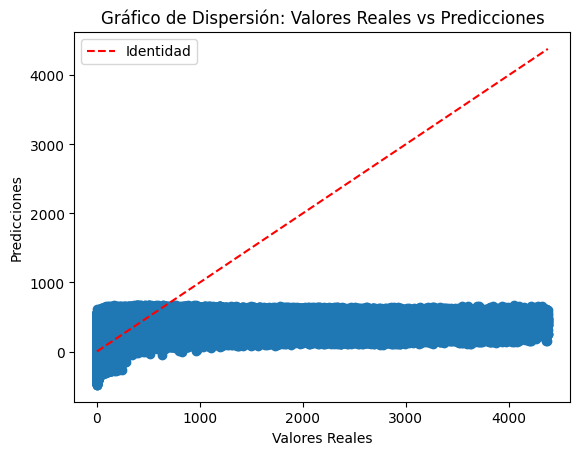

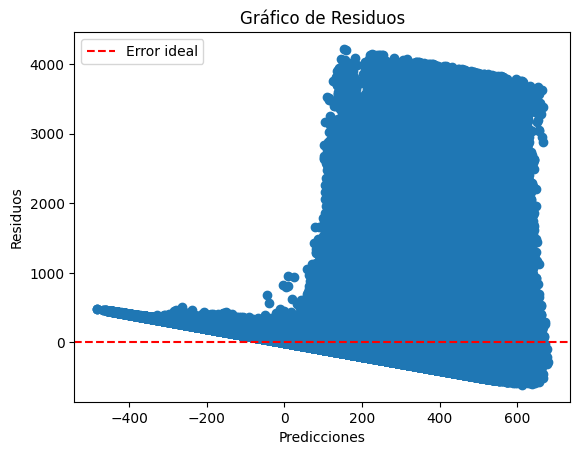

In [ ]:
graph_predictions(y_test, y_pred)

# Random forest

In [20]:
x_train, y_train, x_test, y_test = get_test_train_data("all")

# Instanciar y entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=10)
rf_model.fit(x_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(x_test)

# Evaluar el modelo
mse_rf = pow(root_mean_squared_error(y_test, y_pred_rf), 2)
print("Error cuadrático medio de Random Forest:", mse_rf)


Error cuadrático medio de Random Forest: 9046.923495195404


Error cuadrático medio (MSE): 9046.923495195404
Raíz del Error Cuadrático Medio (RMSE): 95.11531682749842
Error Absoluto Medio (MAE): 26.31871274350843
Coeficiente de Determinación (R²): 0.9593046462494658
Error Absoluto Medio Porcentual (MAPE): 54.432615893304394


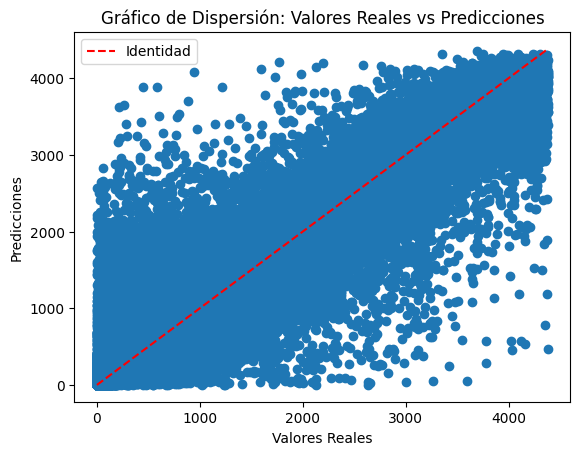

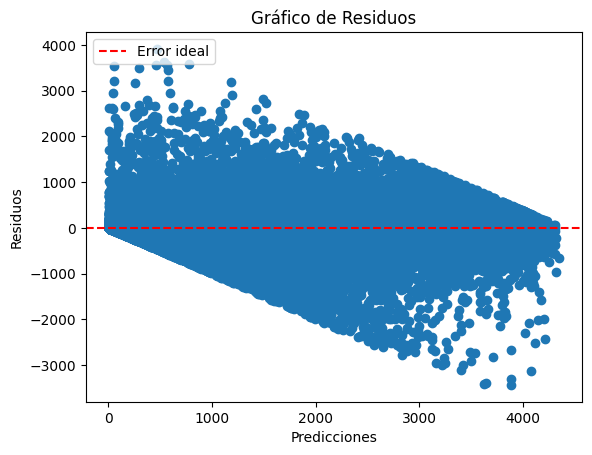

In [21]:
graph_predictions(y_test, y_pred_rf)